In [103]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

In [104]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()

In [105]:
# read the shprt term sites count data from 2016 to 2019
sc=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2014_2019.csv')

In [106]:
sc['Count'].describe()

count    28299.000000
mean        11.387187
std         23.651149
min          0.000000
25%          2.000000
50%          5.000000
75%         12.000000
max       1141.000000
Name: Count, dtype: float64

In [107]:
sc.groupby(['year'])['ID'].count()

year
2014.0    1466
2015.0    2731
2016.0    8983
2017.0    4766
2018.0    6395
2019.0    3958
Name: ID, dtype: int64

In [108]:
sc.groupby(['year'])['Leg'].count()

year
2014.0    1466
2015.0    2731
2016.0    8983
2017.0    4766
2018.0    6395
2019.0    3958
Name: Leg, dtype: int64

In [109]:
sc['Leg'].replace({None: 'unknown'},inplace =True)
sc['matched_seg_id'].replace({None: 'unknown'},inplace =True)

In [110]:
sc.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0


In [111]:
sc.shape

(28299, 25)

In [112]:
sc['matched_seg_id'].nunique()

4264

In [113]:
# find the sites that have only one hour counts
dur=pd.DataFrame({'dur':sc.groupby(['matched_seg_id','Leg','year'])['diff'].sum()}).reset_index()
dur1=dur.loc[dur['dur']==1]
dur1.head()

,matched_seg_id,Leg,year,dur
0,969,E,2016.0,1.0
3,1066,N,2016.0,1.0
7,1392,W,2016.0,1.0
23,4876,N,2014.0,1.0
24,5485,S,2014.0,1.0


In [114]:
dur1['matched_seg_id'].nunique(),sc['matched_seg_id'].nunique(), dur1.shape

(1117, 4264, (1162, 4))

In [115]:
check=sc.loc[sc['Count']>500]
check

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
6144,32670,32670,2495,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1141,N,...,6.0,1,Weekend,06:00:00,07:00:00,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0
6145,32671,32671,2496,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,N,...,6.0,1,Weekend,07:00:00,08:00:00,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0
6153,32691,32691,2516,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1140,S,...,6.0,1,Weekend,06:00:00,07:00:00,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0
6154,32692,32692,2517,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,S,...,6.0,1,Weekend,07:00:00,08:00:00,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0
27968,43124,43124,12949,Eric_Fischer886,2015-07-09,Thursday,16:00,17:00,507,N,...,3.0,0,Week Day,16:00:00,17:00:00,NaN,NaN,2015-07-09 16:00:00,2015-07-09 17:00:00,1.0
27971,43128,43128,12953,Eric_Fischer887,2015-07-09,Thursday,16:00,17:00,507,N,...,3.0,0,Week Day,16:00:00,17:00:00,NaN,NaN,2015-07-09 16:00:00,2015-07-09 17:00:00,1.0


In [116]:
# drop all one hour data 
cond = sc['matched_seg_id'].isin(dur1['matched_seg_id'])
sc.drop(sc[cond].index, inplace = True)
sc.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0


In [117]:
sc['matched_seg_id'].nunique()

3147

In [118]:
#now again check the sites that have only one hour counts
dur=pd.DataFrame({'dur':sc.groupby(['matched_seg_id','Leg','year'])['diff'].sum()}).reset_index()
dur1=dur.loc[dur['dur']==1]
dur1.shape

(0, 4)

In [119]:
#sc['Leg'].isnull().sum()
sc['matched_seg_id'].isnull().sum()

0

In [120]:
sc['Leg'].unique()

array(['N', 'E', 'S', 'W'], dtype=object)

In [121]:
# Winter: Dec, Jan, feb
# spring- March, April, May
#summer- June, july and August
# Autumn- Spetember, October, November

In [122]:
# check the seasonal data collection
winter_mask=sc['month'].isin([12, 1,2])
winter=sc[winter_mask]
spring_mask=sc['month'].isin([3, 4,5])
spring=sc[spring_mask]
summer_mask=sc['month'].isin([6, 7,8])
summer=sc[summer_mask]
autumn_mask=sc['month'].isin([9, 10,11])
autumn=sc[autumn_mask]
autumn.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
220,4078,4078,0,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,119,N,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
221,4080,4080,2,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,41,E,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
222,4082,4082,4,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,127,S,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
223,4084,4084,6,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,23,W,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
224,4086,4086,8,Davis1,2016-11-15,Tuesday,11:00 AM,12:00 PM,85,N,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0


In [123]:
print('winter sites', winter['ID'].nunique())
print('spring sites', spring['ID'].nunique())
print('summer sites', summer['ID'].nunique())
print('autumn sites', autumn['ID'].nunique())

winter sites 478
spring sites 560
summer sites 253
autumn sites 920


In [124]:
# sites collected data in saturdaya nd sunday
sat_sun=sc.loc[sc['Week Day Status']=='Weekend']
sat_sun['ID'].nunique()

178

In [125]:
# Sites collected data from monday to friday
mon_fri=sc.loc[sc['Week Day Status']=='Week Day']
mon_fri['ID'].nunique()

1962

In [126]:
# unique number of sites
sc['ID'].nunique()


2122

In [127]:
location=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/sc_stv_2014_2019.csv')
location.head()

,Unnamed: 0,ID,Leg,year,tdg_id,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,0,Eric_Fischer1089,N,2014.0,60313.0,34.062543,-118.309114,307766980.0,47895363.0,3905.0,865.0,3040.0,NaN,0.778489
1,1,Eric_Fischer1089,E,2014.0,60316.0,34.061703,-118.308480,307766746.0,398048051.0,4970.0,1885.0,3085.0,NaN,0.620724
2,2,Eric_Fischer1089,S,2014.0,60314.0,34.061193,-118.309105,307766737.0,398053760.0,2050.0,620.0,1430.0,NaN,0.697561
3,3,Eric_Fischer1089,W,2014.0,60320.0,34.061700,-118.309727,307766743.0,398048057.0,3560.0,1830.0,1730.0,NaN,0.485955
4,4,Eric_Fischer1086,E,2014.0,44255.0,34.090759,-118.308870,307771629.0,398048112.0,2390.0,905.0,1485.0,NaN,0.621339


In [128]:
# # bring the lat and long
# location=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/SMART3_locations_20201130.csv',encoding='cp1252')
# #location['RecentYear'] = location['RecentYear'].apply(np.int64)
# location=location.rename(columns={'Study_ID':'ID'})
# location.head()

In [129]:
location1=location[['ID','tdg_id', 'Lat', 'Long']]
location1.head()

,ID,tdg_id,Lat,Long
0,Eric_Fischer1089,60313.0,34.062543,-118.309114
1,Eric_Fischer1089,60316.0,34.061703,-118.308480
2,Eric_Fischer1089,60314.0,34.061193,-118.309105
3,Eric_Fischer1089,60320.0,34.061700,-118.309727
4,Eric_Fischer1086,44255.0,34.090759,-118.308870


In [130]:
# Import additional short term location
# add_short=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/ForMintu/ForMintu/sc_missing.shp')
# add_short=add_short.to_crs('epsg:4326')
# add_short["Long"] = add_short.centroid.x
# add_short["Lat"] =add_short.centroid.y
# add_short1=add_short[['ID','Lat', 'Long']]
# #add_short1=add_short1.rename(columns={'syear':'year'})
# add_short1.head()

In [131]:
# c=add_short1.loc[add_short1["ID"]=='Kern504']
# c

In [132]:
# Combine all short term togther
# short_all=pd.concat([location1,add_short1],axis=0)
# short_all.head()

In [133]:
short_all=location1

In [134]:
short_all['ID'].nunique(),short_all['ID'].nunique()

(2340, 2340)

In [135]:
sc['ID'].nunique(), sc.shape

(2122, (26778, 25))

In [136]:
# jpin short term counts sites data with location
sc_loc1=pd.merge(sc, short_all, left_on=['matched_seg_id'], right_on=['tdg_id'], how='inner')
sc_loc1=sc_loc1.rename(columns={'ID_x':'ID'})
sc_loc1.tail()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long
214791,47691,47691,17516,Eric_Fischer1440,2014-02-25,Tuesday,8:00,9:00,1,N,...,09:00:00,NaN,NaN,2014-02-25 08:00:00,2014-02-25 09:00:00,1.0,Eric_Fischer1443,151415.0,37.683706,-122.129499
214792,47705,47705,17530,Eric_Fischer1443,2014-02-25,Tuesday,16:00,17:00,1,N,...,17:00:00,NaN,NaN,2014-02-25 16:00:00,2014-02-25 17:00:00,1.0,Eric_Fischer1440,151415.0,37.683706,-122.129499
214793,47705,47705,17530,Eric_Fischer1443,2014-02-25,Tuesday,16:00,17:00,1,N,...,17:00:00,NaN,NaN,2014-02-25 16:00:00,2014-02-25 17:00:00,1.0,Eric_Fischer1443,151415.0,37.683706,-122.129499
214794,47708,47708,17533,Eric_Fischer1443,2014-02-25,Tuesday,16:00,17:00,4,W,...,17:00:00,NaN,NaN,2014-02-25 16:00:00,2014-02-25 17:00:00,1.0,Eric_Fischer1443,155959.0,37.682648,-122.129421
214795,47711,47711,17536,Eric_Fischer1443,2014-02-25,Tuesday,17:00,18:00,5,W,...,18:00:00,NaN,NaN,2014-02-25 17:00:00,2014-02-25 18:00:00,1.0,Eric_Fischer1443,155959.0,37.682648,-122.129421


In [137]:
sc_loc1['ID'].nunique()

1957

In [138]:
sc_loc1.groupby(['year'])['ID'].count()

year
2014.0      1816
2015.0      4651
2016.0     63541
2017.0    127182
2018.0     11390
2019.0      6216
Name: ID, dtype: int64

# Run QA and QC 
# Daytime hour measure:
     ###  Flag and censor hourly count values that are both
      ### (a) greater than 12 times the mean absolute deviation from the hourly median count in the short-duration sample, and
      ### (b) greater than 50.
### Nighttime hour measure:
    ### Flag and censor hourly count values that are greater than 10.

In [139]:
# Assign day and night
def night_day (starttime):
    if starttime=='08:00:00':
        return 'day'
    elif starttime=='09:00:00':
        return 'day'
    elif starttime=='10:00:00':
        return 'day'   
    elif starttime=='11:00:00':
        return 'day' 
    elif starttime=='12:00:00':
        return 'day'
    elif starttime=='13:00:00':
        return 'day'  
    elif starttime=='14:00:00':
        return 'day' 
    elif starttime=='15:00:00':
        return 'day'    
    elif starttime=='16:00:00':
        return 'day' 
    elif starttime=='17:00:00':
        return 'day' 
    elif starttime=='18:00:00':
        return 'day'
    elif starttime=='19:00:00':
        return 'day' 
    elif starttime=='20:00:00':
        return 'night' 
    elif starttime=='21:00:00':
        return 'night' 
    elif starttime=='22:00:00':
        return 'night'
    elif starttime=='23:00:00':
        return 'night'
    elif starttime=='24:00:00':
        return 'night'
    elif starttime=='00:00:00':
        return 'night'
    elif starttime=='01:00:00':
        return 'night'
    elif starttime=='02:00:00':
        return 'night'
    elif starttime=='03:00:00':
        return 'night'
    elif starttime=='04:00:00':
        return 'night'
    elif starttime=='05:00:00':
        return 'night'
    elif starttime=='06:00:00':
        return 'night'
    else:
        return 'night' 

In [140]:
# apply day night function
sc_loc1['day_night']=sc_loc1.apply(lambda row:night_day(row['starttime']),axis=1)

In [141]:
check=sc_loc1.loc[sc_loc1['ID']=='Miovision81']
check

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night
20069,32670,32670,2495,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1141,N,...,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0,Miovision79,7175.0,38.921179,-120.017078,night
20070,32670,32670,2495,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1141,N,...,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0,Miovision80,7175.0,38.921179,-120.017078,night
20071,32670,32670,2495,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1141,N,...,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0,Miovision81,7175.0,38.921179,-120.017078,night
20072,32671,32671,2496,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,N,...,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0,Miovision79,7175.0,38.921179,-120.017078,night
20073,32671,32671,2496,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,N,...,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0,Miovision80,7175.0,38.921179,-120.017078,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20268,32701,32701,2526,Miovision81,2017-06-04,Sunday,4:00 PM,5:00 PM,5,S,...,NaN,NaN,2017-06-04 16:00:00,2017-06-04 17:00:00,1.0,Miovision80,8692.0,38.920438,-120.017324,day
20269,32701,32701,2526,Miovision81,2017-06-04,Sunday,4:00 PM,5:00 PM,5,S,...,NaN,NaN,2017-06-04 16:00:00,2017-06-04 17:00:00,1.0,Miovision81,8692.0,38.920438,-120.017324,day
20270,32702,32702,2527,Miovision81,2017-06-04,Sunday,5:00 PM,6:00 PM,6,S,...,NaN,NaN,2017-06-04 17:00:00,2017-06-04 18:00:00,1.0,Miovision79,8692.0,38.920438,-120.017324,day
20271,32702,32702,2527,Miovision81,2017-06-04,Sunday,5:00 PM,6:00 PM,6,S,...,NaN,NaN,2017-06-04 17:00:00,2017-06-04 18:00:00,1.0,Miovision80,8692.0,38.920438,-120.017324,day


In [142]:
check['starttime'].unique()

array(['06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00',
       '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00',
       '16:00:00', '17:00:00'], dtype=object)

In [143]:
# day and Night data
sc_day=sc_loc1.loc[sc_loc1['day_night']=='day']
sc_night=sc_loc1.loc[sc_loc1['day_night']=='night']

In [144]:
# Flag greater than 12 times the mean absolute deviation from the hourly median count in the short-duration sample
# sc_day_median=pd.DataFrame({'Median': sc_day.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Count'].median()}).reset_index()
# sc_day_median1=pd.merge(sc_day,sc_day_median, on=['ID','year','Leg','matched_seg_id','Lat','Long'] )
# sc_day_median1['flag_threshold']=12*abs(sc_day_median1["Count"]-sc_day_median1["Median"])
# sc_day_median1.head()

In [145]:
# allow day time maximum 300 and night time maximum 100 bicyclist per hour
c=sc_day.loc[sc_day['Count']>300]
# early morning have 7 am to 8 am have high counts
c1=sc_night.loc[sc_night['Count']>1200]
c.shape,c1.shape

((0, 30), (0, 30))

In [146]:
c

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night


In [147]:
c1

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night


In [148]:
sc_loc1.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'ID_y', 'tdg_id', 'Lat', 'Long', 'day_night'],
      dtype='object')

In [149]:
# Check for high Estimated site
hvolume=sc_loc1.loc[sc_loc1['matched_seg_id']==64682]
hvolume

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night


In [150]:
# Check for high Estimated site
hvolume=sc_loc1['matched_seg_id'].isin([53590,64682,64850,64618,6854,135674,135675])
hvolume1=sc_loc1[hvolume]
hvolume1

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night
1054,4078,4078,0,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,119,N,...,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0,Davis0,135674.0,38.547778,-121.747768,day
1055,4079,4079,1,Davis0,2016-11-15,Tuesday,4:00 PM,5:00 PM,147,N,...,NaN,NaN,2016-11-15 16:00:00,2016-11-15 17:00:00,1.0,Davis0,135674.0,38.547778,-121.747768,day
1058,4082,4082,4,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,127,S,...,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0,Davis0,135675.0,38.545529,-121.747601,day
1059,4083,4083,5,Davis0,2016-11-15,Tuesday,4:00 PM,5:00 PM,176,S,...,NaN,NaN,2016-11-15 16:00:00,2016-11-15 17:00:00,1.0,Davis0,135675.0,38.545529,-121.747601,day


In [151]:
# apply this QA and QC
# sc_day1=sc_day.loc[sc_day['Count']<1200]
# sc_night1=sc_night.loc[sc_night['Count']<101]
# sc_loc=pd.concat([sc_day1,sc_night1],axis=0).reset_index()

In [152]:
sc_loc=sc_loc1

In [153]:
sc_loc['Count'].describe()

count    214796.000000
mean         11.874020
std          15.708106
min           0.000000
25%           4.000000
50%           8.000000
75%          15.000000
max        1141.000000
Name: Count, dtype: float64

In [154]:
# sc_night1['Count'].describe()

In [155]:
# list(c1['ID'].unique())

In [156]:
# Duration of short term sites data collection
sc_duration=pd.DataFrame({'duration':sc_loc.groupby(['ID','year','month','Leg','matched_seg_id','Lat','Long'])['diff'].sum()}).reset_index()
sc_duration.head()

,ID,year,month,Leg,matched_seg_id,Lat,Long,duration
0,AC20160,2016.0,10.0,E,155482,37.695189,-122.072543,12.0
1,AC20160,2016.0,10.0,N,155481,37.696340,-122.073912,12.0
2,AC20160,2016.0,10.0,W,155626,37.695583,-122.075038,12.0
3,AC20161,2016.0,9.0,S,151222,37.699778,-122.108403,4.0
4,AC201610,2016.0,10.0,E,158851,37.890589,-122.293289,8.0


In [157]:
sc_duration['duration'].describe()

count    4631.000000
mean       46.988339
std       131.572035
min         1.000000
25%         4.000000
50%         8.000000
75%        12.000000
max       552.000000
Name: duration, dtype: float64

In [158]:
# check the duration
d=sc_duration[sc_duration['ID'].isin(['Kern357',
 'Kern358',
 'Kern366',
 'Kern3',
 'Kern41',
 'Kern515',
 'Kern522',
 'Kern524',
 'Kern540',
 'Kern563',
 'Kern603',
 'Kern652',
 'Kern654',
 'SLOCOG_SLO_Seg50',
 'SLOCOG_SLO_Seg63',
 'Miovision81',
 'Miovision274'])]
d

,ID,year,month,Leg,matched_seg_id,Lat,Long,duration
1361,Kern3,2017.0,2.0,W,22333,35.366994,-118.916463,3.0
1362,Kern3,2019.0,11.0,W,22333,35.366994,-118.916463,4.0
1411,Kern357,2017.0,1.0,W,24749,35.672595,-119.232976,4.0
1412,Kern358,2017.0,1.0,N,24747,35.672067,-119.232071,4.0
1418,Kern366,2017.0,2.0,N,25663,35.149854,-119.456474,12.0
1459,Kern41,2016.0,12.0,W,28134,35.360752,-119.008408,8.0
1460,Kern41,2019.0,11.0,W,28134,35.360752,-119.008408,8.0
1567,Kern522,2017.0,2.0,N,29037,35.204087,-118.828756,8.0
1568,Kern522,2019.0,9.0,N,29037,35.204087,-118.828756,8.0
1571,Kern524,2017.0,2.0,E,29085,35.205458,-118.827530,16.0


In [159]:
sc['ID'].nunique(),sc_loc['ID'].nunique()

(2122, 1957)

In [160]:
# export useable unique short term sites
sc_loc_unique=sc_loc.drop_duplicates(subset=['ID'], keep='first')
sc_loc_unique.to_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/SC_with_Valid_loc.csv')

In [161]:
# First Separate the counters by weekday and weekend, then Calculate the Max AMI and PMI

In [162]:
sc_loc.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'ID_y', 'tdg_id', 'Lat', 'Long', 'day_night'],
      dtype='object')

#  Imput weekday Daily Volume

In [163]:
# weekend=1 and weekday=0
weekend_hr_data=sc_loc.loc[sc_loc['weekday_Status']==1]
weekday_hr_data=sc_loc.loc[sc_loc['weekday_Status']==0]
weekday_hr_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,CH0,90150.0,38.719357,-121.290428,night
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
2,3434,3434,2,CH0,2018-05-30,Wednesday,2:00 PM,3:00 PM,7,N,...,NaN,NaN,2018-05-30 14:00:00,2018-05-30 15:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
3,3435,3435,3,CH0,2018-05-30,Wednesday,3:00 PM,4:00 PM,11,N,...,NaN,NaN,2018-05-30 15:00:00,2018-05-30 16:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
4,3436,3436,4,CH0,2018-05-30,Wednesday,4:00 PM,5:00 PM,9,N,...,NaN,NaN,2018-05-30 16:00:00,2018-05-30 17:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day


In [164]:
weekday_hr_data['ID'].nunique(),weekend_hr_data['ID'].nunique()

(1828, 147)

In [165]:
# Calculate AM Count by eco id
weekday_am1=weekday_hr_data[(weekday_hr_data['starttime']=='07:00:00')]
weekday_am2=weekday_hr_data[(weekday_hr_data['starttime']=='08:00:00')]
weekday_am=pd.concat([weekday_am1,weekday_am2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181amg=pd.DataFrame({'AM_count' : weekday_am.groupby(['matched_seg_id','year','Leg'])['Count'].sum()}).reset_index()

# Calculate pM count by Eco ID
weekday_pm1=weekday_hr_data[(weekday_hr_data['starttime']=='11:00:00')]
weekday_pm2=weekday_hr_data[(weekday_hr_data['starttime']=='12:00:00')]
df181pm=pd.concat([weekday_pm1,weekday_pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'PM_count' : df181pm.groupby(['matched_seg_id','year','Leg'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_am_pm=pd.merge(df181amg,df181pmg,left_on=['matched_seg_id','year','Leg'],right_on=['matched_seg_id','year','Leg'],how='inner')
# Calculate the AMI
df181_am_pm['AMI']=df181_am_pm['AM_count']/df181_am_pm['PM_count']
df181_am_pm.head()

,matched_seg_id,year,Leg,AM_count,PM_count,AMI
0,1030,2019.0,E,1,5,0.200000
1,1197,2018.0,E,1,11,0.090909
2,1266,2018.0,W,1,14,0.071429
3,1388,2019.0,E,2,5,0.400000
4,1497,2019.0,N,12,22,0.545455


In [166]:
df181_am_pm['matched_seg_id'].nunique()

695

In [167]:
df181_am_pm.groupby(['year','Leg'])['matched_seg_id'].count()

year    Leg
2014.0  E       2
        N       2
        S       5
        W       4
2015.0  E       8
        N       4
        S       6
        W       6
2016.0  E      83
        N      83
        S      80
        W      72
2017.0  E      18
        N      39
        S      28
        W      17
2018.0  E      50
        N      43
        S      38
        W      28
2019.0  E      50
        N      54
        S      42
        W      48
Name: matched_seg_id, dtype: int64

In [168]:
# Calculate AM Count by eco id
df181pm1=weekday_hr_data[(weekday_hr_data['starttime']=='17:00:00')]
df181pm2=weekday_hr_data[(weekday_hr_data['starttime']=='18:00:00')]
df181pm=pd.concat([df181pm1,df181pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'late_PM_count' : df181pm.groupby(['matched_seg_id','year','Leg'])['Count'].sum()}).reset_index()

# Calculate pM count by Eco ID
df181pm2g1=weekday_hr_data[(weekday_hr_data['starttime']=='11:00:00')]
df181pm2g2=weekday_hr_data[(weekday_hr_data['starttime']=='12:00:00')]
df181pm2g=pd.concat([df181pm2g1,df181pm2g2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pm2g=pd.DataFrame({'early_PM_count' : df181pm2g.groupby(['matched_seg_id','year','Leg'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_pm_pm=pd.merge(df181pmg,df181pm2g,left_on=['matched_seg_id','year','Leg'],right_on=['matched_seg_id','year','Leg'],how='inner')
# Calculate the AMI
df181_pm_pm['PMI']=df181_pm_pm['late_PM_count']/df181_pm_pm['early_PM_count']
df181_pm_pm.head()

,matched_seg_id,year,Leg,late_PM_count,early_PM_count,PMI
0,1030,2019.0,E,2,5,0.400000
1,1197,2018.0,E,7,11,0.636364
2,1266,2018.0,W,6,14,0.428571
3,1388,2019.0,E,11,5,2.200000
4,1497,2019.0,N,26,22,1.181818


In [169]:
df181_pm_pm['matched_seg_id'].nunique()

582

In [170]:
df181_pm_pm.groupby(['year','Leg'])['matched_seg_id'].count()

year    Leg
2014.0  E       3
        N       2
        S       5
        W       5
2015.0  E       8
        N       4
        S       6
        W       6
2016.0  E      43
        N      40
        S      32
        W      31
2017.0  E      28
        N      47
        S      33
        W      26
2018.0  E      63
        N      60
        S      52
        W      44
2019.0  E      51
        N      51
        S      42
        W      51
Name: matched_seg_id, dtype: int64

In [171]:
AMI_PMI=pd.merge(df181_am_pm,df181_pm_pm, left_on=['matched_seg_id','year','Leg'], right_on=['matched_seg_id','year','Leg'], how='inner')
AMI_PMI.head(10)

,matched_seg_id,year,Leg,AM_count,PM_count,AMI,late_PM_count,early_PM_count,PMI
0,1030,2019.0,E,1,5,0.200000,2,5,0.400000
1,1197,2018.0,E,1,11,0.090909,7,11,0.636364
2,1266,2018.0,W,1,14,0.071429,6,14,0.428571
3,1388,2019.0,E,2,5,0.400000,11,5,2.200000
4,1497,2019.0,N,12,22,0.545455,26,22,1.181818
5,1497,2019.0,S,2,12,0.166667,18,12,1.500000
6,1605,2019.0,W,2,5,0.400000,2,5,0.400000
7,2062,2019.0,W,2,5,0.400000,7,5,1.400000
8,2126,2018.0,S,16,20,0.800000,8,20,0.400000
9,5820,2019.0,S,8,13,0.615385,4,13,0.307692


In [172]:
AMI_PMI.shape,AMI_PMI["matched_seg_id"].nunique()

((525, 9), 450)

In [173]:
AMI_PMI['matched_seg_id'].nunique()

450

In [174]:
# mask=sc['ID'].isin(location['Study_ID'])
# sc_mis=sc[mask]
# sc_mis.shape

In [175]:
# expoort short term location with missing lat and long
# sc_m=sc[~sc.ID.isin(location.Study_ID)]
# sc_m1=sc_m.drop_duplicates(subset=['ID','Leg','year'], keep='first')
# sc_m1.columns

In [176]:
# sc_m2=sc_m1[['ID', 'year','Leg','matched_seg_id']]
# sc_m2.shape

In [177]:
# sc_m2.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/SC_with_missing_location.csv')

In [178]:
# Calculate the max AMI_PMI Value
def max_weekday_value(Max_weekday_AMI,Max_weekday_PMI):
    if Max_weekday_AMI>Max_weekday_PMI:
        return Max_weekday_AMI
    else:
        return Max_weekday_PMI

In [179]:
AMI_PMI['Max_AMI_PMI']=AMI_PMI.apply(lambda row:max_weekday_value(row['AMI'],row['PMI']),axis=1)
AMI_PMI1=AMI_PMI[['matched_seg_id','year','Leg','Max_AMI_PMI']]
AMI_PMI2=pd.merge(weekday_hr_data,AMI_PMI1,on=['matched_seg_id','year','Leg'], how='inner')
AMI_PMI2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night,Max_AMI_PMI
0,3517,3517,85,CH3,2019-01-23,Wednesday,4:00 AM,5:00 AM,1,W,...,NaN,2019-01-23 04:00:00,2019-01-23 05:00:00,1.0,CH3,90114.0,38.702293,-121.274759,night,0.9
1,3518,3518,86,CH3,2019-01-23,Wednesday,5:00 AM,6:00 AM,1,W,...,NaN,2019-01-23 05:00:00,2019-01-23 06:00:00,1.0,CH3,90114.0,38.702293,-121.274759,night,0.9
2,3519,3519,87,CH3,2019-01-23,Wednesday,6:00 AM,7:00 AM,1,W,...,NaN,2019-01-23 06:00:00,2019-01-23 07:00:00,1.0,CH3,90114.0,38.702293,-121.274759,night,0.9
3,3520,3520,88,CH3,2019-01-23,Wednesday,7:00 AM,8:00 AM,3,W,...,NaN,2019-01-23 07:00:00,2019-01-23 08:00:00,1.0,CH3,90114.0,38.702293,-121.274759,night,0.9
4,3521,3521,89,CH3,2019-01-23,Wednesday,8:00 AM,9:00 AM,4,W,...,NaN,2019-01-23 08:00:00,2019-01-23 09:00:00,1.0,CH3,90114.0,38.702293,-121.274759,day,0.9


In [180]:
AMI_PMI2.shape

(14789, 31)

In [181]:
AMI_PMI2=AMI_PMI2.drop_duplicates(subset=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long','starttime'], keep='first')

In [182]:
AMI_PMI2.shape

(6110, 31)

In [183]:
AMI_PMI.groupby(['year','Leg'])['matched_seg_id'].count()

year    Leg
2014.0  E       2
        N       2
        S       5
        W       4
2015.0  E       8
        N       3
        S       6
        W       5
2016.0  E      25
        N      19
        S      17
        W      15
2017.0  E      18
        N      37
        S      26
        W      16
2018.0  E      42
        N      39
        S      34
        W      24
2019.0  E      48
        N      47
        S      38
        W      45
Name: matched_seg_id, dtype: int64

In [184]:
AMI_PMI.groupby(['year'])['matched_seg_id'].count()

year
2014.0     13
2015.0     22
2016.0     76
2017.0     97
2018.0    139
2019.0    178
Name: matched_seg_id, dtype: int64

In [185]:
# split the data by Max_AMI_PMI Value
AMI_PMI2_g1=AMI_PMI2.loc[AMI_PMI2['Max_AMI_PMI']<=1]
AMI_PMI2_g1=AMI_PMI2_g1.drop(['Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0','Start Time', 'End Time', 'starttime1', 'endtime1','startDateTime',
       'endDateTime'],axis=1)
AMI_PMI2_g2=AMI_PMI2[(AMI_PMI2.Max_AMI_PMI>1) &(AMI_PMI2.Max_AMI_PMI<=2.50)]
AMI_PMI2_g3=AMI_PMI2.loc[AMI_PMI2['Max_AMI_PMI']>2.50]

In [186]:
#AMI_PMI2_g1.loc[AMI_PMI2_g1['ID']=='Kern125']

In [187]:
AMI_PMI1.shape,AMI_PMI2.shape

((525, 4), (6110, 31))

In [188]:
# read the HOD factor for weekday and group it by criteria
HOD=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Final Factor/Final_HOD_Factor.csv')
HOD_weekday=HOD.loc[HOD['day_of_status']=='weekday']
HOD_weekday_g1=HOD_weekday.loc[HOD_weekday['Criteria']=='Max_AMI_PMI<=1']
HOD_weekday_g2=HOD_weekday.loc[HOD_weekday['Criteria']=='1<Max_AMI_PMI<=2.5']
HOD_weekday_g3=HOD_weekday.loc[HOD_weekday['Criteria']=='Max_AMI_PMI>2.5']

In [189]:
HOD_weekday_g1.head()

,Unnamed: 0,starttime,Average_Group_HOD_Factor,Criteria,day_of_status
0,0,00:00:00,0.002970,Max_AMI_PMI<=1,weekday
1,1,01:00:00,0.002145,Max_AMI_PMI<=1,weekday
2,2,02:00:00,0.001953,Max_AMI_PMI<=1,weekday
3,3,03:00:00,0.001807,Max_AMI_PMI<=1,weekday
4,4,04:00:00,0.002084,Max_AMI_PMI<=1,weekday


In [190]:
# Calculate daily Volume for group 1
g1_DV=pd.merge(AMI_PMI2_g1,HOD_weekday_g1, on=['starttime'], how='inner')
g1_DV1=pd.DataFrame({'agge_count' : g1_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
g1_DV1f=pd.DataFrame({'agge_factor' : g1_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
g1_DV1r=pd.merge(g1_DV1,g1_DV1f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
g1_DV1r['Daily_Volume']=g1_DV1r['agge_count']/g1_DV1r['agge_factor']
g1_DV1rf=pd.DataFrame({'TDV' : g1_DV1r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [191]:
g1_DV1.shape,g1_DV1r.shape

((206, 9), (206, 11))

In [192]:
c=g1_DV.loc[g1_DV['Count']==0]
c1=g1_DV1.loc[g1_DV1['agge_count']==0]
c.shape,c1.shape

((0, 26), (0, 9))

In [193]:
# Calculate daily Volume for group 2
g2_DV=pd.merge(AMI_PMI2_g2,HOD_weekday_g2, on=['starttime'], how='inner')
g2_DV2=pd.DataFrame({'agge_count' : g2_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
g2_DV2f=pd.DataFrame({'agge_factor' : g2_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
g2_DV2r=pd.merge(g2_DV2,g2_DV2f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
g2_DV2r['Daily_Volume']=g2_DV2r['agge_count']/g2_DV2r['agge_factor']
g2_DV2rf=pd.DataFrame({'TDV' : g2_DV2r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [194]:
g2_DV2.shape,g2_DV2r.shape

((190, 9), (190, 11))

In [195]:
# Calculate daily Volume for group 3
g3_DV=pd.merge(AMI_PMI2_g3,HOD_weekday_g3, on=['starttime'], how='inner')
g3_DV3=pd.DataFrame({'agge_count' : g3_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
g3_DV3f=pd.DataFrame({'agge_factor' : g3_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
g3_DV3r=pd.merge(g3_DV3,g3_DV3f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
g3_DV3r['Daily_Volume']=g3_DV3r['agge_count']/g3_DV3r['agge_factor']
g3_DV3rf=pd.DataFrame({'TDV' : g3_DV3r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [196]:
g3_DV3.shape,g3_DV3r.shape

((193, 9), (193, 11))

In [197]:
# Apply HOD factor to get Daily Total volume
# g1_DV=pd.merge(AMI_PMI2_g1,HOD_weekday_g1, on=['starttime'], how='inner')
# g1_DV['Daily_Volume']=g1_DV['Count']/g1_DV['Average_Group_HOD_Factor']
# g1_DV1=pd.DataFrame({'TDV' : g1_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# g2_DV=pd.merge(AMI_PMI2_g2,HOD_weekday_g2, on=['starttime'], how='inner')
# g2_DV['Daily_Volume']=g2_DV['Count']/g2_DV['Average_Group_HOD_Factor']
# g2_DV2=pd.DataFrame({'TDV' : g2_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# g3_DV=pd.merge(AMI_PMI2_g3,HOD_weekday_g3, on=['starttime'], how='inner')
# g3_DV['Daily_Volume']=g3_DV['Count']/g3_DV['Average_Group_HOD_Factor']
# g3_DV3=pd.DataFrame({'TDV' : g3_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# g3_DV3.head()

In [198]:
# combine these three group of estimated daily volume together
DV_part1=pd.concat([g1_DV1rf,g2_DV2rf,g3_DV3rf],axis=0).reset_index()
DV_part1.shape

(581, 9)

In [199]:
DV_part1.isnull().sum()

index             0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

<AxesSubplot: >

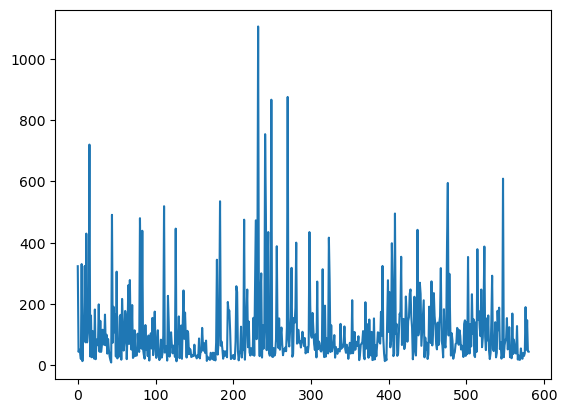

In [200]:
DV_part1['TDV'].plot()

In [201]:
DV_part1.columns

Index(['index', 'year', 'Leg', 'Day of Week', 'month', 'matched_seg_id', 'Lat',
       'Long', 'TDV'],
      dtype='object')

In [202]:
DV_part1['year'].unique()

array([2014., 2015., 2016., 2017., 2018., 2019.])

In [203]:
# it seems still 1992--456= 1536 sites weekday saily volume still need to be estimated
# use Maximum Weekday AMI_PMI= 5.57710+7.58428e-05* population Density -4.76462* Strava Recreational Ratio

In [204]:
# Now find the short term sites in the weekday where Max_AMI_PMI was not able to calculate due to lack of data
common = weekday_hr_data.merge(DV_part1,on=['matched_seg_id', 'year', 'Leg'])
sc_weekday=weekday_hr_data[(~weekday_hr_data.ID.isin(common.ID))]
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,CH0,90150.0,38.719357,-121.290428,night
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
2,3434,3434,2,CH0,2018-05-30,Wednesday,2:00 PM,3:00 PM,7,N,...,NaN,NaN,2018-05-30 14:00:00,2018-05-30 15:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
3,3435,3435,3,CH0,2018-05-30,Wednesday,3:00 PM,4:00 PM,11,N,...,NaN,NaN,2018-05-30 15:00:00,2018-05-30 16:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
4,3436,3436,4,CH0,2018-05-30,Wednesday,4:00 PM,5:00 PM,9,N,...,NaN,NaN,2018-05-30 16:00:00,2018-05-30 17:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day


In [205]:
weekday_hr_data.shape, sc_weekday.shape, DV_part1.shape

((211201, 30), (195679, 30), (581, 9))

In [206]:
weekday_hr_data['matched_seg_id'].nunique(),DV_part1['matched_seg_id'].nunique(),sc_weekday['matched_seg_id'].nunique()

(2516, 450, 2037)

In [207]:
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,CH0,90150.0,38.719357,-121.290428,night
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
2,3434,3434,2,CH0,2018-05-30,Wednesday,2:00 PM,3:00 PM,7,N,...,NaN,NaN,2018-05-30 14:00:00,2018-05-30 15:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
3,3435,3435,3,CH0,2018-05-30,Wednesday,3:00 PM,4:00 PM,11,N,...,NaN,NaN,2018-05-30 15:00:00,2018-05-30 16:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
4,3436,3436,4,CH0,2018-05-30,Wednesday,4:00 PM,5:00 PM,9,N,...,NaN,NaN,2018-05-30 16:00:00,2018-05-30 17:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day


In [208]:
# read Strava recreation ratio data for corresponding short term sites
sc_stv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/sc_stv_2014_2019.csv')
sc_stv.head(8)

,Unnamed: 0,ID,Leg,year,tdg_id,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,0,Eric_Fischer1089,N,2014.0,60313.0,34.062543,-118.309114,307766980.0,47895363.0,3905.0,865.0,3040.0,NaN,0.778489
1,1,Eric_Fischer1089,E,2014.0,60316.0,34.061703,-118.308480,307766746.0,398048051.0,4970.0,1885.0,3085.0,NaN,0.620724
2,2,Eric_Fischer1089,S,2014.0,60314.0,34.061193,-118.309105,307766737.0,398053760.0,2050.0,620.0,1430.0,NaN,0.697561
3,3,Eric_Fischer1089,W,2014.0,60320.0,34.061700,-118.309727,307766743.0,398048057.0,3560.0,1830.0,1730.0,NaN,0.485955
4,4,Eric_Fischer1086,E,2014.0,44255.0,34.090759,-118.308870,307771629.0,398048112.0,2390.0,905.0,1485.0,NaN,0.621339
5,5,Eric_Fischer1086,W,2014.0,44313.0,34.090760,-118.310051,307771624.0,398048110.0,1900.0,830.0,1070.0,NaN,0.563158
6,6,Eric_Fischer1117,E,2014.0,65355.0,34.147891,-118.430403,308067403.0,405318134.0,735.0,80.0,655.0,NaN,0.891156
7,7,Eric_Fischer1117,W,2014.0,65361.0,34.148135,-118.431898,308067452.0,405318136.0,745.0,75.0,670.0,NaN,0.899329


In [209]:
# Calculate the populationden
count_sites=sc_stv
# Use Dr. Frank Code to get population density for each location of the counter within buffer
count_sites['geometry'] = gpd.points_from_xy(count_sites.Long, count_sites.Lat)
count_sites = gpd.GeoDataFrame(count_sites, geometry='geometry', crs='EPSG:4326')
# project the data for geographic analysis
count_sites = count_sites.to_crs(3310)

In [210]:
# Calculate the CBD Distance
## Try to pull whole CA state Network using polygon
# ca_poly=gpd.read_file('H:/Desktop/AT Census/OSM Bike Network/ca-state-boundary/CA_State_TIGER2016.shp',encoding='utf-8')
# ca_poly2=gpd.GeoDataFrame(ca_poly, geometry='geometry', crs='EPSG:3857')
# one_mile=1609.34
# ca_poly2['geometry'] = ca_poly2['geometry'].buffer(one_mile)
# ca_poly3=ca_poly2.to_crs("epsg:4326")
# polygon=ca_poly3.loc[0,'geometry']
# polygon

In [211]:
# Calculate the CBD distance
#https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dtownhall
# Import University
# tags = {'office': 'government'}
# city_hall = ox.geometries_from_polygon(polygon, tags)
# city_proj = city_hall.to_crs(epsg=3310)

In [212]:
# Consider the rows that have city hall
# city_proj1 = city_proj[city_proj['name'].str.contains('City Hall', regex=False, case=False, na=False)]
# city_proj2 = city_proj[city_proj['name'].str.contains('Town Hall', regex=False, case=False, na=False)]
# city_proj3 = city_proj[city_proj['name'].str.contains('Civic Center', regex=False, case=False, na=False)]
# city_proj4 = city_proj[city_proj['name'].str.contains('Administration Building', regex=False, case=False, na=False)]
# city_proj5=pd.concat([city_proj1,city_proj2,city_proj3,city_proj4]).reset_index()
# city_proj5.head(2)

In [213]:
# Distance to CBD
# count_sites['CBD Distance'] = count_sites.geometry.apply(min_distance_ppoly, args=(city_proj5,))*0.000621371
# count_sites=count_sites.reset_index()
# count_sites.head(2)

In [214]:
# count_sites['CBD Distance'].isnull().sum()

In [215]:
#read Block group
block_groups_CA = gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_060_blck_grp_2019/CA_blck_grp_2019.shp')
block_groups_Ne=  gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_320_blck_grp_2019/NV_blck_grp_2019.shp')
block_groups=pd.concat([block_groups_CA,block_groups_Ne],axis=0).set_index('GEOID')
block_groups['aland_sqmi'] = block_groups['ALAND'] / (1609.*1609.)
block_groups.head(2)

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,aland_sqmi
GEOID,,,,,,,,,,,,,,,,
060014001001,G06000104001001,06,001,400100,1,Block Group 1,G5030,S,6894339.0,0.0,+37.8676275,-122.2319460,14302.721555,6.894335e+06,"POLYGON ((-2255602.272 353149.335, -2255597.39...",2.663058
060014002001,G06000104002001,06,001,400200,1,Block Group 1,G5030,S,288069.0,0.0,+37.8497451,-122.2488478,2971.010308,2.880696e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81...",0.111272


In [216]:
bg_pop = pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Block_Gp/pop/nhgis0102_csv/nhgis0102_ds244_20195_blck_grp.csv')
bg_pop['geoid'] = bg_pop['GEOID'].str[7:]
bg_pop = bg_pop.set_index('geoid')
bg_pop = bg_pop.rename(columns={'ALUBE001': 'pop'})
bg_pop.head(2)

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,SDUNIA,PCI,PUMAA,GEOID,BTTRA,BTBGA,NAME_E,pop,NAME_M,ALUBM001
geoid,,,,,,,,,,,,,,,,,,,,,
060014001001,G06000104001001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014001001,NaN,NaN,"Block Group 1, Census Tract 4001, Alameda Coun...",3120,"Block Group 1, Census Tract 4001, Alameda Coun...",208
060014002001,G06000104002001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002001,NaN,NaN,"Block Group 1, Census Tract 4002, Alameda Coun...",990,"Block Group 1, Census Tract 4002, Alameda Coun...",138


In [217]:
block_groups = block_groups.join(bg_pop[['pop']])
# calculate area-weightd average population density - make this a function if needed
count_sites = count_sites.set_index(['tdg_id', 'year'])

block_groups['popden'] = block_groups['pop']/block_groups['aland_sqmi']
block_groups = block_groups.to_crs(3310)

count_sites['buffer_geometry'] = count_sites.buffer(1609.)
count_sites = count_sites.set_geometry('buffer_geometry')

joined_geos = count_sites[['buffer_geometry']].\
    sjoin(block_groups[['geometry']]).\
    join(block_groups[['geometry']], on='index_right')

joined_geos['overlap'] = joined_geos['buffer_geometry'].intersection(joined_geos['geometry']).area

joined_geos['overlap_ratio'] = joined_geos['overlap']/(joined_geos['buffer_geometry'].area)

joined_geos = joined_geos.join(block_groups[['popden']], on='index_right')

joined_geos['weighted_popden'] = joined_geos['overlap_ratio'] * joined_geos['popden']

count_sites['popden'] = joined_geos.groupby(['tdg_id', 'year'])['weighted_popden'].sum()

In [218]:
count_sites = count_sites.set_geometry('geometry').drop(columns='buffer_geometry')

In [219]:
count_sites=count_sites.reset_index()
count_sites.head(2)

,tdg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,60313.0,2014.0,0,Eric_Fischer1089,N,34.062543,-118.309114,307766980.0,47895363.0,3905.0,865.0,3040.0,NaN,0.778489,POINT (156080.152 -437837.271),31855.628241
1,60316.0,2014.0,1,Eric_Fischer1089,E,34.061703,-118.308480,307766746.0,398048051.0,4970.0,1885.0,3085.0,NaN,0.620724,POINT (156140.360 -437929.311),32550.878297


In [220]:
count_sites.to_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')

In [221]:
# separate 2019 and 2018 data as it has strava 
#count_sites1=count_sites[(count_sites['year']==2019)|(count_sites['year']==2018)]
count_sites1=count_sites.reset_index()
count_sites1['stv_rec_ratio'].fillna(0, inplace=True)
count_sites1['popden'].fillna(1, inplace=True)
count_sites1.head()

,index,tdg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,0,60313.0,2014.0,0,Eric_Fischer1089,N,34.062543,-118.309114,307766980.0,47895363.0,3905.0,865.0,3040.0,NaN,0.778489,POINT (156080.152 -437837.271),31855.628241
1,1,60316.0,2014.0,1,Eric_Fischer1089,E,34.061703,-118.308480,307766746.0,398048051.0,4970.0,1885.0,3085.0,NaN,0.620724,POINT (156140.360 -437929.311),32550.878297
2,2,60314.0,2014.0,2,Eric_Fischer1089,S,34.061193,-118.309105,307766737.0,398053760.0,2050.0,620.0,1430.0,NaN,0.697561,POINT (156083.639 -437986.952),31741.126338
3,3,60320.0,2014.0,3,Eric_Fischer1089,W,34.061700,-118.309727,307766743.0,398048057.0,3560.0,1830.0,1730.0,NaN,0.485955,POINT (156025.260 -437931.735),30898.086056
4,4,44255.0,2014.0,4,Eric_Fischer1086,E,34.090759,-118.308870,307771629.0,398048112.0,2390.0,905.0,1485.0,NaN,0.621339,POINT (156046.884 -434707.306),26375.825438


In [222]:
count_sites1['stv_rec_ratio'].isnull().sum()

0

In [223]:
count_sites1['ID'].nunique()

2340

# Now estimate Weekday Max AMI_PMI 


In [224]:
a=3.77571742
b= 9.29116576e-05
c= -3.10154018e+00
count_sites1['Max_AMI_PMI']=a+b*count_sites1['popden']+c*np.power(count_sites1['stv_rec_ratio'],2)
count_sites1.head(3)

,index,tdg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
0,0,60313.0,2014.0,0,Eric_Fischer1089,N,34.062543,-118.309114,307766980.0,47895363.0,3905.0,865.0,3040.0,NaN,0.778489,POINT (156080.152 -437837.271),31855.628241,4.855803
1,1,60316.0,2014.0,1,Eric_Fischer1089,E,34.061703,-118.308480,307766746.0,398048051.0,4970.0,1885.0,3085.0,NaN,0.620724,POINT (156140.360 -437929.311),32550.878297,5.605054
2,2,60314.0,2014.0,2,Eric_Fischer1089,S,34.061193,-118.309105,307766737.0,398053760.0,2050.0,620.0,1430.0,NaN,0.697561,POINT (156083.639 -437986.952),31741.126338,5.215656


In [225]:
count_sites1['Max_AMI_PMI'].describe()

count    5704.000000
mean        3.828025
std         4.217390
min         0.676088
25%         1.732626
50%         2.884823
75%         4.123158
max        23.173368
Name: Max_AMI_PMI, dtype: float64

In [226]:
#count_sites2=count_sites[(count_sites['year']==2016)|(count_sites['year']==2017)]
count_sites1['popden'].fillna(1, inplace=True)

In [227]:
#count_sites1['popden'].isnull().sum(),count_sites1['CBD Distance'].isnull().sum()

In [228]:
count_sites1['tdg_id'].nunique()

3608

In [229]:
# Strava is missing for 2016 and 2017, therefore,now use Maximum Weekday AMI_PMI= -0.32406+0.03444*√("population Density" ) +𝟎.𝟎𝟒𝟐𝟖𝟑∗𝐥𝐧(𝐃𝐢𝐬𝐭𝐚𝐧𝐜𝐞 𝐭𝐨 𝐂𝐁𝐃 𝐢𝐧 𝐦𝐢𝐥𝐞) to 
#calculate max AMI_PMI for 2016 and 2017 data 
#count_sites2=count_sites[(count_sites['year']==2016)|(count_sites['year']==2017)]
# a=-0.32406
# b=0.03444
# c=0.04283
# count_sites2['Max_AMI_PMI']=a+b*np.sqrt(count_sites2['popden'])+c*np.log(count_sites2['CBD Distance'])
# count_sites2.head()

In [230]:
# count_sites1['Max_AMI_PMI'].isnull().sum(), count_sites2['Max_AMI_PMI'].isnull().sum()

In [231]:
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,CH0,90150.0,38.719357,-121.290428,night
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
2,3434,3434,2,CH0,2018-05-30,Wednesday,2:00 PM,3:00 PM,7,N,...,NaN,NaN,2018-05-30 14:00:00,2018-05-30 15:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
3,3435,3435,3,CH0,2018-05-30,Wednesday,3:00 PM,4:00 PM,11,N,...,NaN,NaN,2018-05-30 15:00:00,2018-05-30 16:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day
4,3436,3436,4,CH0,2018-05-30,Wednesday,4:00 PM,5:00 PM,9,N,...,NaN,NaN,2018-05-30 16:00:00,2018-05-30 17:00:00,1.0,CH0,90150.0,38.719357,-121.290428,day


In [232]:
# Now combine count_sites1 and count sites 2 data
#count_sites3=pd.concat([count_sites1,count_sites2],axis=0)
count_sites4=pd.merge(sc_weekday,count_sites1,on=['tdg_id','year'], how='inner')
count_sites4.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID_x,Date,Day of Week,Start Time,End Time,Count,Leg_x,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,310765843.0,502900510.0,170.0,130.0,40.0,0.764706,0.235294,POINT (-112075.942 78908.375),4995.892305,4.068182
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,310765843.0,502900510.0,170.0,130.0,40.0,0.764706,0.235294,POINT (-112075.942 78908.375),4995.892305,4.068182
2,3434,3434,2,CH0,2018-05-30,Wednesday,2:00 PM,3:00 PM,7,N,...,310765843.0,502900510.0,170.0,130.0,40.0,0.764706,0.235294,POINT (-112075.942 78908.375),4995.892305,4.068182
3,3435,3435,3,CH0,2018-05-30,Wednesday,3:00 PM,4:00 PM,11,N,...,310765843.0,502900510.0,170.0,130.0,40.0,0.764706,0.235294,POINT (-112075.942 78908.375),4995.892305,4.068182
4,3436,3436,4,CH0,2018-05-30,Wednesday,4:00 PM,5:00 PM,9,N,...,310765843.0,502900510.0,170.0,130.0,40.0,0.764706,0.235294,POINT (-112075.942 78908.375),4995.892305,4.068182


In [233]:
sc_weekday['tdg_id'].nunique(), count_sites4['tdg_id'].nunique()

(2037, 2037)

In [234]:
count_sites4=count_sites4.rename(columns={"Leg_x":'Leg'})
count_sites4=count_sites4.rename(columns={"Lat_x":'Lat'})
count_sites4=count_sites4.rename(columns={"Long_x":'Long'})

In [235]:
count_sites1['Max_AMI_PMI'].isnull().sum(), count_sites4['Max_AMI_PMI'].isnull().sum()

(0, 0)

In [236]:
sc_weekday.shape,count_sites1.shape

((195679, 30), (5704, 18))

In [237]:
sc_weekday['tdg_id'].nunique(),count_sites4['tdg_id'].nunique()

(2037, 2037)

In [238]:
# split by MAX AMI_PMI Value
m_g1=count_sites4.loc[count_sites4['Max_AMI_PMI']<=1]
m_g2=count_sites4[(count_sites4.Max_AMI_PMI>1) &(count_sites4.Max_AMI_PMI<=2.50)]
m_g3=count_sites4.loc[count_sites4['Max_AMI_PMI']>2.50]
m_g3.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID_x,Date,Day of Week,Start Time,End Time,Count,Leg,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,310765843.0,502900510.0,170.0,130.0,40.0,0.764706,0.235294,POINT (-112075.942 78908.375),4995.892305,4.068182
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,310765843.0,502900510.0,170.0,130.0,40.0,0.764706,0.235294,POINT (-112075.942 78908.375),4995.892305,4.068182


In [239]:
m_g1.shape,m_g2.shape,m_g3.shape,count_sites4.shape

((1590, 46), (13245, 46), (8764188, 46), (8779023, 46))

In [240]:
m_g3.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID_x', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'ID_y', 'tdg_id', 'Lat', 'Long', 'day_night', 'index', 'Unnamed: 0_y',
       'ID_y', 'Leg_y', 'Lat_y', 'Long_y', 'edgeUID', 'osmId', 'stv_total',
       'stv_com_total', 'stv_rec_total', 'stv_com_ratio', 'stv_rec_ratio',
       'geometry', 'popden', 'Max_AMI_PMI'],
      dtype='object')

In [241]:
# Calculate daily Volume for group 1
mg1_DV=pd.merge(m_g1,HOD_weekday_g1, on=['starttime'], how='inner')
mg1_DV1=pd.DataFrame({'agge_count' : mg1_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
mg1_DV1f=pd.DataFrame({'agge_factor' : mg1_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
mg1_DV1r=pd.merge(mg1_DV1,mg1_DV1f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
mg1_DV1r['Daily_Volume']=mg1_DV1r['agge_count']/mg1_DV1r['agge_factor']
mg1_DV1rf=pd.DataFrame({'TDV' : mg1_DV1r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [242]:
c=mg1_DV.loc[mg1_DV['Count']==0]
c1=mg1_DV1.loc[mg1_DV1['agge_count']==0]
c.shape,c1.shape

((0, 50), (0, 9))

In [243]:
mg1_DV1rf.isnull().sum()

year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [244]:
# Calculate daily Volume for group 2
mg2_DV=pd.merge(m_g2,HOD_weekday_g2, on=['starttime'], how='inner')
mg2_DV2=pd.DataFrame({'agge_count' : mg2_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
mg2_DV2f=pd.DataFrame({'agge_factor' : mg2_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
mg2_DV2r=pd.merge(mg2_DV2,mg2_DV2f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
mg2_DV2r['Daily_Volume']=mg2_DV2r['agge_count']/mg2_DV2r['agge_factor']
mg2_DV2rf=pd.DataFrame({'TDV' : mg2_DV2r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [245]:
c=mg2_DV.loc[mg2_DV['Count']==0]
c1=mg2_DV2.loc[mg2_DV2['agge_count']==0]
c.shape,c1.shape

((247, 50), (12, 9))

In [246]:
mg2_DV2.shape,mg2_DV2f.shape,mg2_DV2r.shape

((1139, 9), (1139, 9), (1139, 11))

In [247]:
c=mg2_DV2r.loc[mg2_DV2r['agge_count']==0]
c.shape

(12, 11)

In [248]:
mg2_DV2r.isnull().sum()

year              0
month             0
day               0
Leg               0
Day of Week       0
matched_seg_id    0
Lat               0
Long              0
agge_count        0
agge_factor       0
Daily_Volume      0
dtype: int64

In [249]:
# Calculate daily Volume for group 3
mg3_DV=pd.merge(m_g3,HOD_weekday_g3, on=['starttime'], how='inner')
mg3_DV3=pd.DataFrame({'agge_count' : mg3_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
mg3_DV3f=pd.DataFrame({'agge_factor' : mg3_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
mg3_DV3r=pd.merge(mg3_DV3,mg3_DV3f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
mg3_DV3r['Daily_Volume']=mg3_DV3r['agge_count']/mg3_DV3r['agge_factor']
mg3_DV3rf=pd.DataFrame({'TDV' : mg3_DV3r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [250]:
c=mg3_DV.loc[mg3_DV['Count']==0]
c1=mg3_DV3.loc[mg3_DV3['agge_count']==0]
c.shape,c1.shape

((200, 50), (14, 9))

In [251]:
mg3_DV3rf.isnull().sum()

year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [252]:
# Apply factor to obtain daily Volume
# mg1_DV=pd.merge(m_g1,HOD_weekday_g1, on=['starttime'], how='inner')
# mg1_DV['Daily_Volume']=mg1_DV['Count']/mg1_DV['Average_Group_HOD_Factor']
# mg1_DV1=pd.DataFrame({'TDV' : mg1_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# mg2_DV=pd.merge(m_g2,HOD_weekday_g2, on=['starttime'], how='inner')
# mg2_DV['Daily_Volume']=mg2_DV['Count']/mg2_DV['Average_Group_HOD_Factor']
# mg2_DV2=pd.DataFrame({'TDV' : mg2_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# mg3_DV=pd.merge(m_g3,HOD_weekday_g3, on=['starttime'], how='inner')
# mg3_DV['Daily_Volume']=mg3_DV['Count']/mg3_DV['Average_Group_HOD_Factor']
# mg3_DV3=pd.DataFrame({'TDV' : mg3_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# mg3_DV3.head()

In [253]:
mg1_DV1rf.shape, mg1_DV1r.shape

((242, 8), (242, 11))

In [254]:
# combine these three group of estimated daily volume together
DV_part2=pd.concat([mg1_DV1rf,mg2_DV2rf,mg3_DV3rf],axis=0).reset_index()
DV_part2.shape

(3217, 9)

In [255]:
DV_part2.isnull().sum()

index             0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [256]:
DV_part2.head()

,index,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,0,2014.0,E,Thursday,7.0,108466,35.196107,-120.700363,41.410369
1,1,2014.0,E,Thursday,7.0,108831,35.195876,-120.697624,61.792726
2,2,2014.0,E,Thursday,9.0,107843,35.045348,-120.568661,28.515399
3,3,2014.0,E,Thursday,9.0,109495,35.442174,-120.891010,86.604208
4,4,2014.0,E,Thursday,9.0,109742,35.449183,-120.905062,65.675815


<AxesSubplot: >

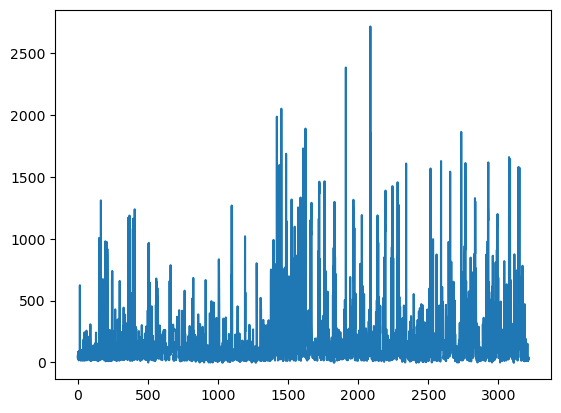

In [257]:
DV_part2['TDV'].plot()

In [258]:
# Combine all Estimated weekday Daily Volume
Weekday_DV=pd.concat([DV_part1,DV_part2],axis=0)
Weekday_DV.shape

(3798, 9)

# Now Estimate weekend Daily Volume

In [259]:
weekend_hr_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime1,endtime1,startDateTime,endDateTime,diff,ID_y,tdg_id,Lat,Long,day_night
78,3537,3537,105,CH4,2019-03-16,Saturday,1:00 PM,2:00 PM,3,E,...,NaN,NaN,2019-03-16 13:00:00,2019-03-16 14:00:00,1.0,CH5,90046.0,38.680814,-121.323644,day
79,3537,3537,105,CH4,2019-03-16,Saturday,1:00 PM,2:00 PM,3,E,...,NaN,NaN,2019-03-16 13:00:00,2019-03-16 14:00:00,1.0,CH4,90046.0,38.680814,-121.323644,day
80,3538,3538,106,CH4,2019-03-16,Saturday,2:00 PM,3:00 PM,4,E,...,NaN,NaN,2019-03-16 14:00:00,2019-03-16 15:00:00,1.0,CH5,90046.0,38.680814,-121.323644,day
81,3538,3538,106,CH4,2019-03-16,Saturday,2:00 PM,3:00 PM,4,E,...,NaN,NaN,2019-03-16 14:00:00,2019-03-16 15:00:00,1.0,CH4,90046.0,38.680814,-121.323644,day
92,3540,3540,108,CH4,2019-03-16,Saturday,1:00 PM,2:00 PM,4,W,...,NaN,NaN,2019-03-16 13:00:00,2019-03-16 14:00:00,1.0,CH5,89763.0,38.681015,-121.328998,day


In [260]:
weekend_hr_data['Count'].min()

0

In [261]:
count_sites=count_sites.drop(['Leg','Lat','Long'],axis=1)
count_sites.head(2)

,tdg_id,year,Unnamed: 0,ID,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,60313.0,2014.0,0,Eric_Fischer1089,307766980.0,47895363.0,3905.0,865.0,3040.0,NaN,0.778489,POINT (156080.152 -437837.271),31855.628241
1,60316.0,2014.0,1,Eric_Fischer1089,307766746.0,398048051.0,4970.0,1885.0,3085.0,NaN,0.620724,POINT (156140.360 -437929.311),32550.878297


In [262]:
weekend_hr_data.shape, count_sites.shape

((3595, 30), (5704, 13))

In [263]:
weekend_hr_data1=pd.merge(weekend_hr_data,count_sites,on=['tdg_id','year'], how='inner')
weekend_hr_data1.shape

(12467, 41)

In [264]:
weekend_hr_data1.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID_x,Date,Day of Week,Start Time,End Time,Count,Leg,...,ID_y,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,3537,3537,105,CH4,2019-03-16,Saturday,1:00 PM,2:00 PM,3,E,...,CH5,310757401.0,540655759.0,205.0,110.0,95.0,0.536585,0.463415,POINT (-115020.415 74664.331),12885.136357
1,3537,3537,105,CH4,2019-03-16,Saturday,1:00 PM,2:00 PM,3,E,...,CH4,310757401.0,540655759.0,205.0,110.0,95.0,0.536585,0.463415,POINT (-115020.415 74664.331),12885.136357
2,3537,3537,105,CH4,2019-03-16,Saturday,1:00 PM,2:00 PM,3,E,...,CH5,310757401.0,540655759.0,205.0,110.0,95.0,0.536585,0.463415,POINT (-115020.415 74664.331),12885.136357
3,3537,3537,105,CH4,2019-03-16,Saturday,1:00 PM,2:00 PM,3,E,...,CH4,310757401.0,540655759.0,205.0,110.0,95.0,0.536585,0.463415,POINT (-115020.415 74664.331),12885.136357
4,3538,3538,106,CH4,2019-03-16,Saturday,2:00 PM,3:00 PM,4,E,...,CH5,310757401.0,540655759.0,205.0,110.0,95.0,0.536585,0.463415,POINT (-115020.415 74664.331),12885.136357


In [265]:
weekend_hr_data1.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID_x', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'ID_y', 'tdg_id', 'Lat', 'Long', 'day_night', 'Unnamed: 0_y', 'ID_y',
       'edgeUID', 'osmId', 'stv_total', 'stv_com_total', 'stv_rec_total',
       'stv_com_ratio', 'stv_rec_ratio', 'geometry', 'popden'],
      dtype='object')

In [266]:
weekend_hr_data1['starttime'].isnull().sum()

0

In [267]:
weekend_hr_data['tdg_id'].nunique(),weekend_hr_data1['tdg_id'].nunique()

(272, 272)

In [268]:
# weekend_hr_data1=weekend_hr_data1.rename(columns={"Leg_x":'Leg'})
# weekend_hr_data1=weekend_hr_data1.rename(columns={"Lat_x":'Lat'})
# weekend_hr_data11=weekend_hr_data1.rename(columns={"Long_x":'Long'})

In [269]:
# Split the weekend data by strava recreational threshold to apply factor
w_g1=weekend_hr_data1.loc[weekend_hr_data1['stv_rec_ratio']<=0.75]
w_g2=weekend_hr_data1.loc[weekend_hr_data1['stv_rec_ratio']>0.75]
w_g2.tail(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID_x,Date,Day of Week,Start Time,End Time,Count,Leg,...,ID_y,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
12465,26169,26169,620,SLO_Co57,2014-09-28,Sunday,1/1/1900 16:00,1/1/1900 17:00,2,W,...,SLO_Co57,307209478.0,10570333.0,1910.0,40.0,1870.0,NaN,0.979058,POINT (-99182.042 -271972.562),573.584379
12466,26170,26170,621,SLO_Co57,2014-09-28,Sunday,1/1/1900 17:00,1/1/1900 18:00,2,W,...,SLO_Co57,307209478.0,10570333.0,1910.0,40.0,1870.0,NaN,0.979058,POINT (-99182.042 -271972.562),573.584379


In [270]:
weekend_hr_data1['stv_rec_ratio'].isnull().sum()

0

In [271]:
w_g1.shape,w_g2.shape, weekend_hr_data1.shape

((802, 41), (11665, 41), (12467, 41))

In [272]:
# Split the factor by criteria
HOD_weekend=HOD.loc[HOD['day_of_status']=='weekend']
HOD_weekend_g1=HOD_weekend.loc[HOD_weekend['Criteria']=='Average_stv_rec_ratio<=0.75']
HOD_weekend_g2=HOD_weekend.loc[HOD_weekend['Criteria']=='Average_stv_rec_ratio>0.75']
HOD_weekend_g1.head()

,Unnamed: 0,starttime,Average_Group_HOD_Factor,Criteria,day_of_status
72,0,00:00:00,0.012375,Average_stv_rec_ratio<=0.75,weekend
73,1,01:00:00,0.007436,Average_stv_rec_ratio<=0.75,weekend
74,2,02:00:00,0.005741,Average_stv_rec_ratio<=0.75,weekend
75,3,03:00:00,0.004020,Average_stv_rec_ratio<=0.75,weekend
76,4,04:00:00,0.003764,Average_stv_rec_ratio<=0.75,weekend


In [273]:
weekend_hr_data1.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID_x', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'ID_y', 'tdg_id', 'Lat', 'Long', 'day_night', 'Unnamed: 0_y', 'ID_y',
       'edgeUID', 'osmId', 'stv_total', 'stv_com_total', 'stv_rec_total',
       'stv_com_ratio', 'stv_rec_ratio', 'geometry', 'popden'],
      dtype='object')

In [274]:
# Calculate daily Volume for group 1
wg1_DV=pd.merge(w_g1,HOD_weekend_g1, on=['starttime'], how='inner')
wg1_DV1=pd.DataFrame({'agge_count' : wg1_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
wg1_DV1f=pd.DataFrame({'agge_factor' : wg1_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
wg1_DV1r=pd.merge(wg1_DV1,wg1_DV1f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
wg1_DV1r['Daily_Volume']=wg1_DV1r['agge_count']/wg1_DV1r['agge_factor']
wg1_DV1rf=pd.DataFrame({'TDV' : wg1_DV1r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [275]:
c=wg1_DV.loc[wg1_DV['Count']==0]
c1=wg1_DV1.loc[wg1_DV1['agge_count']==0]
c.shape,c1.shape

((2, 45), (0, 9))

In [276]:
# Calculate daily Volume for group 1
wg2_DV=pd.merge(w_g2,HOD_weekend_g2, on=['starttime'], how='inner')
wg2_DV2=pd.DataFrame({'agge_count' : wg2_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
wg2_DV2f=pd.DataFrame({'agge_factor' : wg2_DV.groupby(['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
wg2_DV2r=pd.merge(wg2_DV2,wg2_DV2f, on=['year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
wg2_DV2r['Daily_Volume']=wg2_DV2r['agge_count']/wg2_DV2r['agge_factor']
wg2_DV2rf=pd.DataFrame({'TDV' : wg2_DV2r.groupby(['year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [277]:
c=wg2_DV.loc[wg2_DV['Count']==0]
c1=wg2_DV2.loc[wg2_DV2['agge_count']==0]
c.shape,c1.shape

((6, 45), (0, 9))

In [278]:
# Apply factor to obtain daily Volume
# wg1_DV=pd.merge(w_g1,HOD_weekend_g1, on=['starttime'], how='inner')
# wg1_DV['Daily_Volume']=wg1_DV['Count']/wg1_DV['Average_Group_HOD_Factor']
# wg1_DV1=pd.DataFrame({'TDV' : wg1_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# wg2_DV=pd.merge(w_g2,HOD_weekend_g2, on=['starttime'], how='inner')
# wg2_DV['Daily_Volume']=wg2_DV['Count']/wg2_DV['Average_Group_HOD_Factor']
# wg2_DV2=pd.DataFrame({'TDV' : wg2_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [279]:
# combine these three group of estimated daily volume together
Weekend_DV_part1=pd.concat([wg1_DV1rf,wg2_DV2rf],axis=0).reset_index()
Weekend_DV_part1.shape

(336, 9)

In [280]:
 weekend_hr_data1.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID_x', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'ID_y', 'tdg_id', 'Lat', 'Long', 'day_night', 'Unnamed: 0_y', 'ID_y',
       'edgeUID', 'osmId', 'stv_total', 'stv_com_total', 'stv_rec_total',
       'stv_com_ratio', 'stv_rec_ratio', 'geometry', 'popden'],
      dtype='object')

In [281]:
Weekend_DV_part1.columns

Index(['index', 'year', 'Leg', 'Day of Week', 'month', 'matched_seg_id', 'Lat',
       'Long', 'TDV'],
      dtype='object')

In [282]:
# Now find the short term sites in the weekend where strava recreation data was not available to calculate due to lack of data
common = weekend_hr_data1.merge(Weekend_DV_part1,on=['matched_seg_id', 'year', 'Leg'])
weekend_hr_data2=weekend_hr_data1[(~weekend_hr_data1.matched_seg_id.isin(common.matched_seg_id))]
weekend_hr_data2=weekend_hr_data2.drop(['stv_rec_ratio'],axis=1)
weekend_hr_data2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID_x,Date,Day of Week,Start Time,End Time,Count,Leg,...,Unnamed: 0_y,ID_y,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,geometry,popden


In [283]:
# Now estimate Strava recreation Ratio using the formula Strava Recreational Ratio (SRR)= 0.96967-0.00303*√("population Density" ) +𝟎.𝟎𝟐𝟑𝟗𝟓∗𝐥𝐧(𝐃𝐢𝐬𝐭𝐚𝐧𝐜𝐞 𝐭𝐨 𝐂𝐁𝐃 𝐢𝐧 𝐦𝐢𝐥𝐞)
# a=0.96967
# b=-0.00303
# c=0.02395
# weekend_hr_data2['stv_rec_ratio']=a+b*np.sqrt(weekend_hr_data2['popden'])+c*np.log(weekend_hr_data2['CBD Distance'])
# weekend_hr_data2.head()

In [284]:
#weekend_hr_data2['stv_rec_ratio'].describe()

In [285]:
# Split the weekend data by strava recreational threshold to apply factor
# w_g11=weekend_hr_data2.loc[weekend_hr_data2['stv_rec_ratio']<=0.75]
# w_g22=weekend_hr_data2.loc[weekend_hr_data2['stv_rec_ratio']>0.75]
# w_g22.tail(2)

In [286]:
# Apply factor to obtain daily Volume
# wg11_DV=pd.merge(w_g11,HOD_weekend_g1, on=['starttime'], how='inner')
# wg11_DV['Daily_Volume']=wg11_DV['Count']/wg11_DV['Average_Group_HOD_Factor']
# wg11_DV11=pd.DataFrame({'TDV' : wg11_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# wg22_DV=pd.merge(w_g22,HOD_weekend_g2, on=['starttime'], how='inner')
# wg22_DV['Daily_Volume']=wg22_DV['Count']/wg22_DV['Average_Group_HOD_Factor']
# wg22_DV22=pd.DataFrame({'TDV' : wg22_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [287]:
# combine these three group of estimated daily volume together
# Weekend_DV_part2=pd.concat([wg11_DV11,wg22_DV22],axis=0).reset_index()
# Weekend_DV_part2.shape

In [288]:
# combine weekend total estimated daily volume data
Weekend_DV=Weekend_DV_part1

<AxesSubplot: >

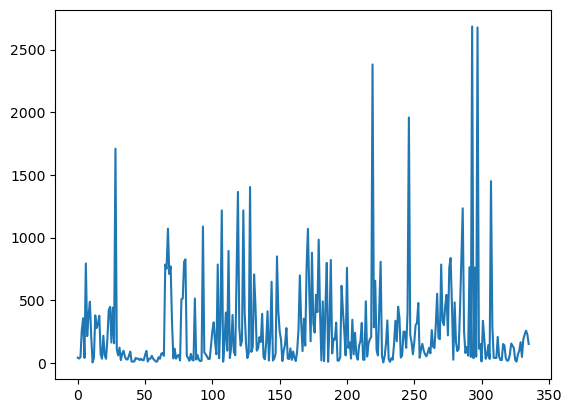

In [289]:
Weekend_DV['TDV'].plot()

In [290]:
Weekend_DV['matched_seg_id'].nunique()

272

# Combine weekday and weekend Estimated Daily Volume

In [291]:
ES_DV=pd.concat([Weekday_DV, Weekend_DV],axis=0).reset_index()
#ES_DV=ES_DV.drop_duplicates(subset=['ID','year','Leg','matched_seg_id','Lat','Long'], keep='first')
ES_DV.head()

,level_0,index,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,0,0,2014.0,E,Thursday,5.0,6191,37.916293,-122.026658,323.429092
1,1,1,2014.0,N,Thursday,5.0,6274,37.919106,-122.065131,44.209732
2,2,2,2014.0,S,Thursday,5.0,6002,37.916497,-122.027719,51.190216
3,3,3,2014.0,S,Thursday,5.0,6127,37.917992,-122.065518,44.209732
4,4,4,2014.0,S,Thursday,5.0,6192,37.884941,-122.077718,20.941452


In [292]:
zero=ES_DV.loc[ES_DV['TDV']==0]
zero.shape

(26, 10)

In [293]:
ES_DV['matched_seg_id'].nunique(),zero['matched_seg_id'].nunique()

(2569, 19)

In [294]:
ES_DV.groupby(['year'])['matched_seg_id'].count()

year
2014.0     257
2015.0     394
2016.0    1448
2017.0     500
2018.0    1167
2019.0     368
Name: matched_seg_id, dtype: int64

In [295]:
ES_DV.groupby(['year'])['matched_seg_id'].nunique()

year
2014.0     226
2015.0     306
2016.0    1204
2017.0     479
2018.0     957
2019.0     294
Name: matched_seg_id, dtype: int64

<AxesSubplot: >

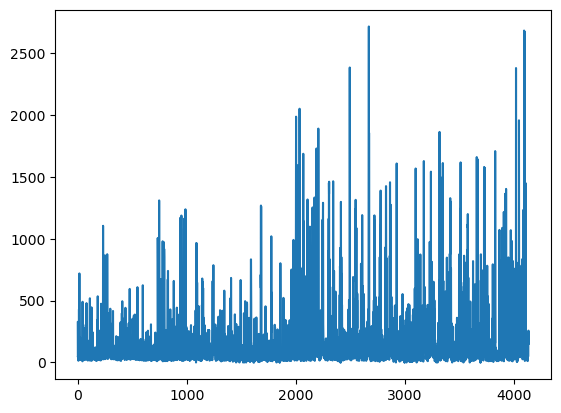

In [296]:
ES_DV['TDV'].plot()

In [297]:
ES_DV.isnull().sum()

level_0           0
index             0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [298]:
anomally=ES_DV.loc[ES_DV['TDV']>4000]
anomally

,level_0,index,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV


In [299]:
an1=sc.loc[sc['ID']=='Miovision81']
an1.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
6144,32670,32670,2495,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1141,N,...,6.0,1,Weekend,06:00:00,07:00:00,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0
6145,32671,32671,2496,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,N,...,6.0,1,Weekend,07:00:00,08:00:00,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0
6146,32672,32672,2497,Miovision81,2017-06-04,Sunday,8:00 AM,9:00 AM,81,N,...,6.0,1,Weekend,08:00:00,09:00:00,NaN,NaN,2017-06-04 08:00:00,2017-06-04 09:00:00,1.0
6147,32673,32673,2498,Miovision81,2017-06-04,Sunday,9:00 AM,10:00 AM,28,N,...,6.0,1,Weekend,09:00:00,10:00:00,NaN,NaN,2017-06-04 09:00:00,2017-06-04 10:00:00,1.0
6148,32674,32674,2499,Miovision81,2017-06-04,Sunday,10:00 AM,11:00 AM,17,N,...,6.0,1,Weekend,10:00:00,11:00:00,NaN,NaN,2017-06-04 10:00:00,2017-06-04 11:00:00,1.0


In [300]:
ES_DV.to_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_DV_feb19.csv',index=False)

# End of the Code